# Parameter Estimation (and Hypothesis testing... which is just parameter estimation)

In our `MagicCoin` example `n` was an example of a parameter. It's some important value for our understanding of how things work that we don't know. By using probability and data we can come up with ways to estimate what these parameters might be.

In the rest of this tutorial we'll focus on an admittedly boring case of trying to estimate the rate that a product sells. The rate being the parameter we're trying to estimate.

We'll be using a simulated product and customer data...

In [1]:
from context import src
from src import customer as cust
from src import product as prod
from src import experiment as exp


import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

Let's start by creating a new product. Our `Product` class is amazingly simple. It just takes a `name`, a `price` and a `quality`. Of course `quality` of a product is not so easy, but in this case we can just set it to whatever we want to simulate the average reviews are.

We'll start with a toothbrush:

In [2]:
toothbrush = prod.Product(name="alright brush",
                          price=4.99,
                          quality=3.9)

It's not the most amazing toothbrush, but let's try to sell it to somebody. Our `Customer` class can generate a random customer for us that has a certain price threshold and quality threshold that we don't know, and varies from customer to customer:

In [3]:
person_a = cust.Customer.get_random()

Next we can show our customer the product using the `will_purchase` method and we'll get a bool back telling us whether or not the decided to purchase that product:

In [4]:
person_a.will_purchase(toothbrush)

False

Like the `MagicCoin` we don't really know what's going on inside of our customer. This singular observation doesn't tell us very much about how our coin behaves. The best way to handle this is to run some sort of an `Experiment`!

We can create an experiment using our `Experiment` class which will help us collect data on customers that we've shown our `toothbrush` to!

In [5]:
toothbrush_test = exp.Experiment(toothbrush)

Now we can use our experiment to show this `toothbrush` to a bunch of customers and see how many will purchase it!

In [6]:
test_result = toothbrush_test.show_to_customers(20)

Now we can see how our test went...

In [7]:
test_result.purchased

0      True
1     False
2      True
3     False
4     False
5     False
6      True
7     False
8     False
9     False
10    False
11    False
12    False
13     True
14    False
15    False
16    False
17    False
18    False
19    False
Name: purchased, dtype: bool

With the `MagicCoin` we understood exactly how it worked so we didn't need a model to represent how we think the `ModelCoin` worked.

Even though the interaction between the `Customer` and the `Product` is more complicated that simply a probability that a `Customer` will purchase a `Product` from our view the best way to model this is to make the simplifying assumption that each `Product` sells on at a particular rate.

If you've worked in ecommerce or any similar conversion focused industry it might seem obvious that we want to estimate "the rate that a product sells", but it's good to remember that this is really an application of probability. If we knew everything about each customer and each product and how they interact we would know exactly how a product sells, there would be no rate involved at all!

So if you wanted to estimate a rate at what this product sells, what would be your first estimate? Most people intuitively might estimate:

In [8]:
sold = sum(test_result.purchased)
total = len(test_result.purchased)
rate_est = sold/total
print("{0} sold out of {1} total so our estimate is {2}".format(sold,total,rate_est))

4 sold out of 20 total so our estimate is 0.2


Making our `rate_est` as `sold/total` seems like a pretty good idea. But how can we show this is the best estimate, and are there other good estimate?

For example what about `rate_est + 0.05` or  `rate_est - 0.05`? Are these good estimate? certainly they explain the data pretty well. How would we compare these estimates?

One way we can do this is to use the Binomial distribution. The Binomial distribution will tell us exactly how likely data would be given this was the rate of a product selling. Let's look at the probability of the data for each of these alternate options:

In [9]:
bin_est = stats.binom(n=total,p=rate_est)
bin_est.pmf(sold)

0.21819940194609996

In [10]:
bin_est_bit_smaller = stats.binom(n=total,p=rate_est-0.05)
bin_est_bit_smaller.pmf(sold)

0.18212167211195038

In [11]:
bin_est_bit_bigger = stats.binom(n=total,p=rate_est+0.05)
bin_est_bit_bigger.pmf(sold)

0.1896854548658663

In both cases we can see that the slightly different estimates are a bit more surprised by the data that we observed. This means that they are not quite a good of an explaination of the data.. but that doesn't mean they're *wrong*.

If you flipped a coin 3 times and got 1 head, you wouldn't assume the probability of heads is $\frac{1}{3}$ the coin being fair is still pretty likely and you know that most coins tend to be fair so the belief that the probability of heads is $\frac{1}{2}$

Rather than just worry about which estimate for the rate is the best, it might be a good idea to look at how strongly we believe in multi estimates. We could start by looking at estimates in intervals of every 0.05 and apply the same logic using the Binomial Distribution we did before. We can use `numpy` to quickly do this in a vectorized way:

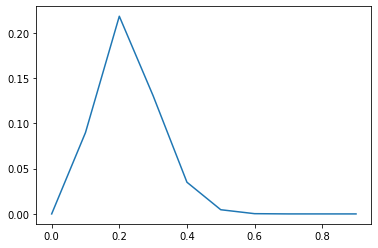

In [12]:
est_dists = stats.binom(total,np.arange(0,1,0.1))
sns.lineplot(x=np.arange(0,1,0.1),
              y=est_dists.pmf(sold))

Here we can see that if we look at each possibility between 0 and 1 incrementing by 0.05 we have some sort of distribution forming. 

We can see that this continues to smooth as we shrink our increment size:

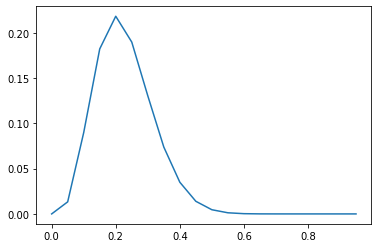

In [13]:
est_dists = stats.binom(total,np.arange(0,1,0.05))
sns.lineplot(x=np.arange(0,1,0.05),
              y=est_dists.pmf(sold))

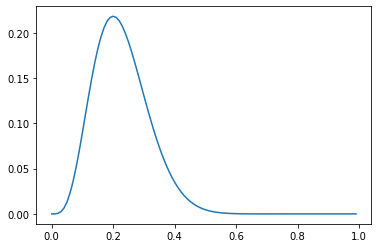

In [14]:
est_dists = stats.binom(total,np.arange(0,1,0.01))
sns.lineplot(x=np.arange(0,1,0.01),
              y=est_dists.pmf(sold))

### The Beta Distribution

The distribution we're converging on is a very useful distribution call the *Beta distribution*. It differs from our plot above in two ways: First it is a continous distribution meaning it accounts for the infinitely many possible rates for what we've observed. The second is that it makes it so that if we sum up over all those possible points (technically integrate) the result is exactly 1. This let's us talk about probabilities for different values. 

The Beta distribution takes two paramters $\alpha$ the number of successes or `True` values we oberved and $\beta$ the number failures or `False` values. Note that this is bit different than the Binomial where `n` = `alpha+beta`

Here's a plot of what this distribution looks like for our cases of `alpha = sold` and `beta = total - sold`

**note:** because the Beta distribution is continuous we'll use the `.pdf` method rather than the `.pmf` method.

[Text(0, 0.5, 'density'), Text(0.5, 0, 'rate estimate')]

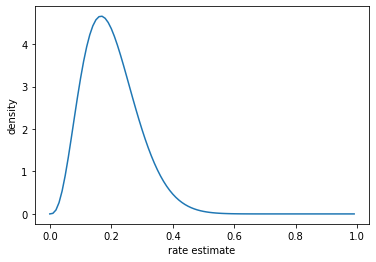

In [15]:
alpha = sold
beta = total - sold
est_beta_dist = stats.beta(alpha,beta)
xs = np.arange(0,1,0.01)
sns.lineplot(x=xs,
             y=est_beta_dist.pdf(xs)).set(xlabel='rate estimate', 
                                          ylabel='density')

Now we have a plot that shows the distribution of how strongly we believe in various possible rates for our `toothbrush` to sell to a custuomer.

The power of having a distribution like this is that we use it to ask questions about our beliefs.

For example: suppose the director of marketing came in an asked if you had a product she could feature on the company webiste. The catch is she wants a product that will have a rate of *at least* 0.4.

Looking at the distribution of our beliefs it's certainly possible that it could be at least 0.4, but how confindent are we?

We can answer this question a few ways. One way would be to use calculus to integrate between 0.4 and 1.0. But plenty of people are a bit nervous about doing calculus, and it turns out that integration gets tricky no matter what, so what we can also do is simply sample from this distribution:

In [16]:
n_samples = 10000
rate_est_samples = np.random.beta(a=sold,b=(total-sold),size=n_samples)

Here we have a vector of samples of our rate estimate and we can use them to answer questions like the directors:

In [17]:
sum(rate_est_samples > 0.4)/n_samples

0.0235

Notice that if we compute the `mean` of these `rate_est_samples` get a result very similar to `sold/total`. 

In [18]:
rate_est_samples.mean()

0.20043462897328226

This is no coincidence. It turns out that the analytical *expectation* (or mean) of the Beta distribution is 

$$E[Beta(\alpha,\beta)] = \frac{\alpha}{\alpha + \beta}$$

Which is the same as the successes over the total. If we sample more from out distribution the answers to the questions we ask of those samples are going to be closer and to the answer we would get if we perform the correct mathematical operations on our function. This is super important because it means we can use sampling as a subsitute for increasingly complicated integrals.

So if you aren't super comfortable with the math, definitely feel free to just use sample... and even if you *are* comfortable with the math, pretty soon you'll need to rely on sampling techniques anyway so you should start playing around with sampling in your analysis

## Hypothesis testing: comparing two products

Hypothesis testing is the essential parts of statistics. It's fancy way of saying you have some hypothesis about the data and you want to test out how likely that hypothesis is. In fact, we've already done hypthesis testing: we asked about the hypothesis of each possible rate that could explain the data, and also looked at the hypothesis that that rate is greater than 0.4

But typically when people think of hypothesis tests they think of comparing some things like:

- do patients that recieve the treatment get healthy faster
- is the new version of the website have more sign-ups than the old
- does saying "Florida" make people think of being old and then walk slower than people who don't hear it.

So to explore hypothesis testing we're going to have to have something to compare our `tooth brush` with, which is our `luxury_toothbrush`:

In [29]:
luxury_toothbrush = prod.Product(name="luxury toothbrush",
                                 price=7.99,
                                 quality=4.8)

This is a much better toothbrush, but it also costs more, how well will it do? And more important, how well will it do compared to just our regular `toothbrush`? 

To look at this let's set up a new experiment, this time one where we can compare both toothbrushes to each other:

In [30]:
toothbrush_ab_test = exp.Experiment(toothbrush,luxury_toothbrush)

We're calling this an AB test because it's similar in nature to an AB test for websites. We're going to show each variant, the original `toothbrush` and the `luxury_toothbrush` to different groups of people and see which one does better.

In [35]:
n_ab_test_samples = 30
ab_test_results = toothbrush_ab_test.show_to_customers(n_ab_test_samples)

We now showed each toothbrush to 30 different people here's the results for each tooth brush

For `toothbrush` we get:

In [36]:
ab_test_results[['a_purchased']]

,a_purchased
0,True
1,False
2,False
3,False
4,False
5,False
6,True
7,False
8,False
9,False


And for `luxury_toothbrush`:

In [37]:
ab_test_results[['b_purchased']]

,b_purchased
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,True


In [38]:
a_sold = sum(ab_test_results.a_purchased)
b_sold = sum(ab_test_results.b_purchased)
print("A sold {} (rate {:.2f}) and B sold {}  (rate {:.2f})".format(a_sold,
                                                      float(a_sold/n_ab_test_samples),
                                                      b_sold,
                                                      float(b_sold/n_ab_test_samples)))

A sold 3 (rate 0.10) and B sold 2  (rate 0.07)


So which toothbrush is beter? And if you think you're sure rerun these cells a few times and you're likely to get different results!

To better understand what's happening here look at our parameter estimates for each tooth brush

In [39]:
alpha_a = sum(ab_test_results.a_purchased)
beta_a = n_ab_test_samples - alpha_a 
a_beta_dist = stats.beta(alpha_a,beta_a)

alpha_b = sum(ab_test_results.b_purchased)
beta_b = n_ab_test_samples - alpha_b 
b_beta_dist = stats.beta(alpha_b,beta_b)
rates = np.arange(0,0.5,0.005)
plot_df = pd.DataFrame({
    'density':np.concatenate((a_beta_dist.pdf(rates),
                              b_beta_dist.pdf(rates))),
    'rate': np.concatenate((rates,rates)),
    'group':['regular']*len(rates) + ['luxury']*len(rates)
})

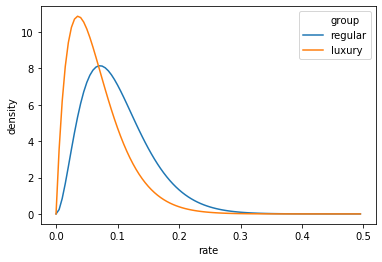

In [40]:
sns.lineplot(x='rate',
             y='density',
             hue='group',
             data=plot_df)

We can se that we have two estimates now that might tell us very different things. If you look at your neighbors' plots (if you're in the live workshop) you might notice a very different plot based on which customers looked at the times.

this means that we don't have enough data to tell which distribution is different. What if we had more customers?

Let's try 100 customers for each brush and see what we learn:

In [41]:
n_ab_test_2_samples = 100
ab_test_2 = toothbrush_ab_test.show_to_customers(n_ab_test_2_samples)

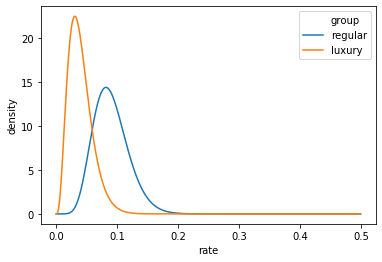

In [42]:
#notice that we're over writing the variables here so be careful of what order you run these cells in!
alpha_a = sum(ab_test_2.a_purchased)
beta_a = n_ab_test_2_samples - alpha_a 
a_beta_dist = stats.beta(alpha_a,beta_a)

alpha_b = sum(ab_test_2.b_purchased)
beta_b = n_ab_test_2_samples - alpha_b 
b_beta_dist = stats.beta(alpha_b,beta_b)
rates = np.arange(0,0.5,0.001)
plot_df = pd.DataFrame({
    'density':np.concatenate((a_beta_dist.pdf(rates),
                              b_beta_dist.pdf(rates))),
    'rate': np.concatenate((rates,rates)),
    'group':['regular']*len(rates) + ['luxury']*len(rates)
})
sns.lineplot(x='rate',
             y='density',
             hue='group',
             data=plot_df)

Now we're getting much better results! There's still a lot of uncertainity around exactly what rate each toothbrush sells, but we can clearly see that our estimates for `luxury_toothbrush` are much lower than they are for regular. Even if you look at your neighbors' plots this time, they should look much more similar.

But we might want to quantify *exactly* how certain we are that the `toothbrush` is doing better than the `luxury_toothbrush`. The best way to do that is with sampling:

In [43]:
total_samples = 10000
regular_samples = np.random.beta(a=alpha_a,b=beta_a,size=total_samples)
luxury_samples = np.random.beta(a=alpha_b,b=beta_b,size=total_samples)

This will tell the probability that the regular toothbrushes sell better than luxury:

In [44]:
sum(regular_samples >luxury_samples)/total_samples

0.9315

As we can see we are almost certain that this is the case, even though we have a lot different beliefs about how well the different toothbrushes convert.

Just to be clear, we just did a hypothesis test! The **hypothesis** was that variant A was better than variant B, and the result of that test was the probability we got from our simulation. The great thing about this test is we don't have a "p value" we have the actual probability that the `toothbrush` is superior based on our simulation.

## Homework

Here are some things you can experiment around with on your own to get a better sense of how hypothesis tests work!

We can see that the `luxury_toothbrush` sells at a lower rate than the `toothbrush` but there are still many questions we can ask. How *much* better do we think `toothbrush` is than `luxury_toothbrush` in terms of how many times better it converts?

In [this post on the Count Bayesie blog](https://www.countbayesie.com/blog/2015/4/25/bayesian-ab-testing) I go over ways that you can add a prior probability (and in [this post](https://www.countbayesie.com/blog/2015/2/18/hans-solo-and-bayesian-priors) talk a bit about what prior probabilities are). Experiment with using a reasonable prior probability for the different purchase rates and see how much sooner (or longer) it takes to conclude that `luxury_toothbrush` is inferior.


`luxury_toothbrush` sells at a lower rate, but it also is more expensive. When we take into account the price difference with the sales difference is the plain old `toothbrush` the better product? or would we be better off selling less of the better tooth brush?